# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
profile

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [4]:
transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [6]:
# Get the channel options
channels_vec=[]
for i in range(len(portfolio['channels'])):
    channels_vec.extend(portfolio['channels'][i])

In [7]:
channels_vec=np.array(channels_vec)
channels_vec_unique=np.unique(channels_vec)
channels_vec_unique

array(['email', 'mobile', 'social', 'web'], 
      dtype='<U6')

In [8]:
for channels_item in channels_vec_unique:
    temp_vec=[]
    for i in range(len(portfolio['channels'])):
        t_or_f=channels_item in portfolio['channels'][i]
        temp_vec.append(t_or_f)
    portfolio[channels_item]=temp_vec

In [9]:
portfolio

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,True,True,True,False
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,True,True,True,True
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,True,True,False,True
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,True,True,False,True
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,True,False,False,True
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,True,True,True,True
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,True,True,True,True
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,True,True,True,False
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,True,True,True,True
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,True,True,False,True


In [10]:
type_of_event=[]
for i in range(len(transcript['value'])):
        type_of_event.append(list(transcript['value'][i].items())[0][0])
    

In [11]:
type_of_event=np.array(type_of_event)
np.unique(type_of_event)

array(['amount', 'offer id', 'offer_id'], 
      dtype='<U8')

In [12]:
# Create 2 new columns: offer_id and amount
offer_id_vec=[]
amount_vec=[]
for i in range(len(transcript['value'])):
    if(list(transcript['value'][i].items())[0][0]=='offer id' or list(transcript['value'][i].items())[0][0]=='offer_id'):
        offer_id_vec.append(list(transcript['value'][i].items())[0][1])
        amount_vec.append('NaN')
    else:
        offer_id_vec.append('NaN')
        amount_vec.append(list(transcript['value'][i].items())[0][1])

In [13]:
transcript['offer_id']=offer_id_vec
transcript['amount']=amount_vec


In [13]:
transcript

,event,person,time,value,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [14]:
# Merge the dataframes properly
portfolio.rename(columns = {'id':'offer_id'}, inplace = True)
profile.rename(columns = {'id':'person'}, inplace = True)

In [15]:
# use 'outer' join to keep all rows
df_trans_port= transcript.merge(portfolio, on='offer_id',how='outer')

In [18]:
df_trans_port_prof=df_trans_port.merge(profile, on='person', how='outer')

In [19]:
df_trans_port_prof

,event,person,time,value,offer_id,amount,channels,difficulty,duration,offer_type,reward,email,mobile,social,web,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0,True,True,False,True,75,20170509,F,100000.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0,True,True,False,True,75,20170509,F,100000.0
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0,True,True,False,True,75,20170509,F,100000.0
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,"[web, email, mobile, social]",5.0,5.0,bogo,5.0,True,True,True,True,75,20170509,F,100000.0
4,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,NaN,"[web, email, mobile, social]",5.0,5.0,bogo,5.0,True,True,True,True,75,20170509,F,100000.0
5,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,582,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,"[web, email, mobile, social]",5.0,5.0,bogo,5.0,True,True,True,True,75,20170509,F,100000.0
6,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd,NaN,"[email, mobile, social]",10.0,7.0,bogo,10.0,True,True,True,False,75,20170509,F,100000.0
7,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd,NaN,"[email, mobile, social]",10.0,7.0,bogo,10.0,True,True,True,False,75,20170509,F,100000.0
8,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,NaN,"[email, mobile, social]",10.0,7.0,bogo,10.0,True,True,True,False,75,20170509,F,100000.0
9,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,NaN,"[email, mobile, social]",0.0,3.0,informational,0.0,True,True,True,False,75,20170509,F,100000.0


# Exploratory analysis

In [18]:
# What types of events are there?
df_trans_port_prof.event.unique()

array(['offer received', 'offer viewed', 'offer completed', 'transaction'], dtype=object)

In [19]:
# Handling missing values
# There are some (ca 10 %) missing values in gender, income
# I 'm not impute them, because I have no other variables which can help
df_trans_port_prof.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 19 columns):
event               306534 non-null object
person              306534 non-null object
time                306534 non-null int64
value               306534 non-null object
offer_id            306534 non-null object
amount              306534 non-null object
channels            167581 non-null object
difficulty          167581 non-null float64
duration            167581 non-null float64
offer_type          167581 non-null object
reward              167581 non-null float64
email               167581 non-null object
mobile              167581 non-null object
social              167581 non-null object
web                 167581 non-null object
age                 306534 non-null int64
became_member_on    306534 non-null int64
gender              272762 non-null object
income              272762 non-null float64
dtypes: float64(4), int64(3), object(12)
memory usage: 46.8+ MB


In [20]:
df_trans_port_prof.describe()

,time,difficulty,duration,reward,age,became_member_on,income
count,306534.000000,167581.000000,167581.000000,167581.00000,306534.000000,3.065340e+05,272762.000000
mean,366.382940,7.850401,6.610737,4.41991,60.909367,2.016545e+07,64337.000755
std,200.326314,5.048944,2.136130,3.37336,26.032030,1.190460e+04,21243.762941
min,0.000000,0.000000,3.000000,0.00000,18.000000,2.013073e+07,30000.000000
25%,186.000000,5.000000,5.000000,2.00000,43.000000,2.016032e+07,48000.000000
50%,408.000000,10.000000,7.000000,5.00000,57.000000,2.017041e+07,62000.000000
75%,528.000000,10.000000,7.000000,5.00000,72.000000,2.017113e+07,78000.000000
max,714.000000,20.000000,10.000000,10.00000,118.000000,2.018073e+07,120000.000000


# Discover the heuristics

In [ ]:
# I will try to tell which offer is the best for each demographic groups (based on age and gender)
# There will be no machine learning models, just pure analysis

In [26]:
# We have the data of 17 000 people
len(df_trans_port_prof.groupby(['person']).count())

17000

In [20]:
# Create new varibles for future analysis
age_group_vec=[]
q_33,q_66=df_trans_port_prof.age.quantile([0.33,0.66])

for i in range(len(df_trans_port_prof)):
    if (df_trans_port_prof.age[i]<q_33):
        age_group=1
    elif (df_trans_port_prof.age[i]<q_66):
        age_group=2
    else:
        age_group=3
    age_group_vec.append(age_group)



In [22]:
print('Age 0.33 quantile: ',q_33,'\n','Age 0.66 quantile: ',q_66)

Age 0.33 quantile:  49.0 
 Age 0.66 quantile:  66.0


In [33]:
df_trans_port_prof['age_group']=age_group_vec

In [43]:
df_whole_grouped=df_trans_port_prof.groupby(['offer_type','age_group','gender','event'],as_index=False).count()
df_whole_grouped

,offer_type,age_group,gender,event,person,time,value,offer_id,amount,channels,difficulty,duration,reward,email,mobile,social,web,age,became_member_on,income
0,bogo,1,F,offer completed,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893
1,bogo,1,F,offer received,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939
2,bogo,1,F,offer viewed,2525,2525,2525,2525,2525,2525,2525,2525,2525,2525,2525,2525,2525,2525,2525,2525
3,bogo,1,M,offer completed,2566,2566,2566,2566,2566,2566,2566,2566,2566,2566,2566,2566,2566,2566,2566,2566
4,bogo,1,M,offer received,6092,6092,6092,6092,6092,6092,6092,6092,6092,6092,6092,6092,6092,6092,6092,6092
5,bogo,1,M,offer viewed,5023,5023,5023,5023,5023,5023,5023,5023,5023,5023,5023,5023,5023,5023,5023,5023
6,bogo,1,O,offer completed,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76
7,bogo,1,O,offer received,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114
8,bogo,1,O,offer viewed,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103
9,bogo,2,F,offer completed,3237,3237,3237,3237,3237,3237,3237,3237,3237,3237,3237,3237,3237,3237,3237,3237


In [59]:
rows=[]
for age_groups in df_whole_grouped.age_group.unique():
    print('Age group: ', age_groups,'\n')
    for genders in df_whole_grouped.gender.unique():
        print('Gender: ', genders,'\n')
        for offer_types in ['bogo','discount']:
            print('Offer type: ', offer_types)
            received_offer_num=int(df_whole_grouped[(df_whole_grouped['offer_type']==offer_types) & (df_whole_grouped['age_group']==age_groups) & (df_whole_grouped['gender']==genders) & (df_whole_grouped['event']=='offer received')]['person'])
            completed_offer_num=int(df_whole_grouped[(df_whole_grouped['offer_type']==offer_types) & (df_whole_grouped['age_group']==age_groups) & (df_whole_grouped['gender']==genders) & (df_whole_grouped['event']=='offer completed')]['person'])
            completed_offer_perc= (completed_offer_num/ received_offer_num)*100
            print(completed_offer_perc,'\n')
            row_vec=[age_groups,genders,offer_types,completed_offer_perc]
            rows.append(row_vec)
            

Age group:  1 

Gender:  F 

Offer type:  bogo
64.40966315073155 

Offer type:  discount
68.74566874566874 

Gender:  M 

Offer type:  bogo
42.120814182534474 

Offer type:  discount
52.699854061942595 

Gender:  O 

Offer type:  bogo
66.66666666666666 

Offer type:  discount
61.78861788617886 

Age group:  2 

Gender:  F 

Offer type:  bogo
71.12722478576137 

Offer type:  discount
74.61340206185567 

Gender:  M 

Offer type:  bogo
54.33000712758375 

Offer type:  discount
61.555036810917585 

Gender:  O 

Offer type:  bogo
69.85294117647058 

Offer type:  discount
78.0 

Age group:  3 

Gender:  F 

Offer type:  bogo
68.03443328550932 

Offer type:  discount
74.03704792708027 

Gender:  M 

Offer type:  bogo
54.13812785388128 

Offer type:  discount
62.9076838032062 

Gender:  O 

Offer type:  bogo
71.15384615384616 

Offer type:  discount
67.02127659574468 



In [63]:
# Plotting the results
results_df=pd.DataFrame(rows, columns=['age_group', 'gender','offer_type','compl_perc_value'])
results_df

,age_group,gender,offer_type,compl_perc_value
0,1,F,bogo,64.409663
1,1,F,discount,68.745669
2,1,M,bogo,42.120814
3,1,M,discount,52.699854
4,1,O,bogo,66.666667
5,1,O,discount,61.788618
6,2,F,bogo,71.127225
7,2,F,discount,74.613402
8,2,M,bogo,54.330007
9,2,M,discount,61.555037


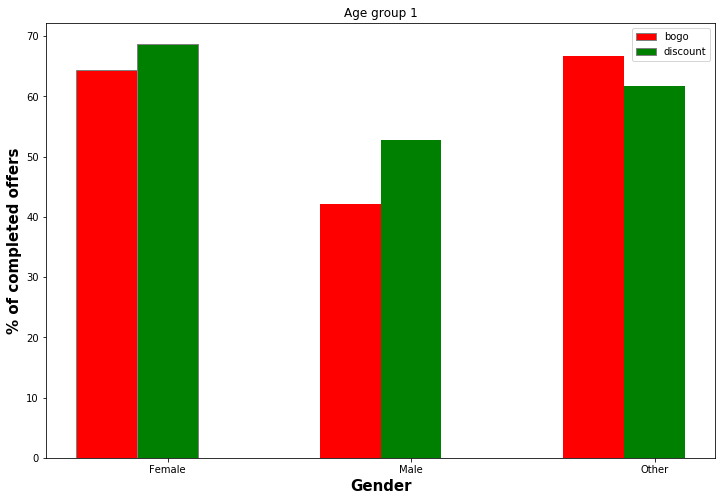

In [80]:
from matplotlib import pyplot as plt
# Figure Size
#fig = plt.figure(figsize =(10, 7))
fig = plt.subplots(figsize =(12, 8))

barwidth= 0.25

br1 = np.arange(len(results_df[(results_df['age_group']==1)&(results_df['offer_type']=='bogo')]['gender']))
br2 = [x + barwidth for x in br1]
# Horizontal Bar Plot
plt.bar(br1, results_df[(results_df['age_group']==1)&(results_df['offer_type']=='bogo')]['compl_perc_value'],
       color ='r',width = barwidth,
        edgecolor ='grey', label ='bogo')
plt.bar(br2, results_df[(results_df['age_group']==1)&(results_df['offer_type']=='discount')]['compl_perc_value'], color ='g',width = barwidth,
        edgecolor ='grey', label ='discount') 

# Adding Xticks
plt.xlabel('Gender', fontweight ='bold', fontsize = 15)
plt.ylabel('% of completed offers', fontweight ='bold', fontsize = 15)
plt.xticks([r + barwidth for r in range(len(results_df[(results_df['age_group']==1)&(results_df['offer_type']=='bogo')]['gender']))],
        ['Female', 'Male', 'Other'])

plt.legend()
plt.title('Age group 1')
# Show Plot
plt.show()

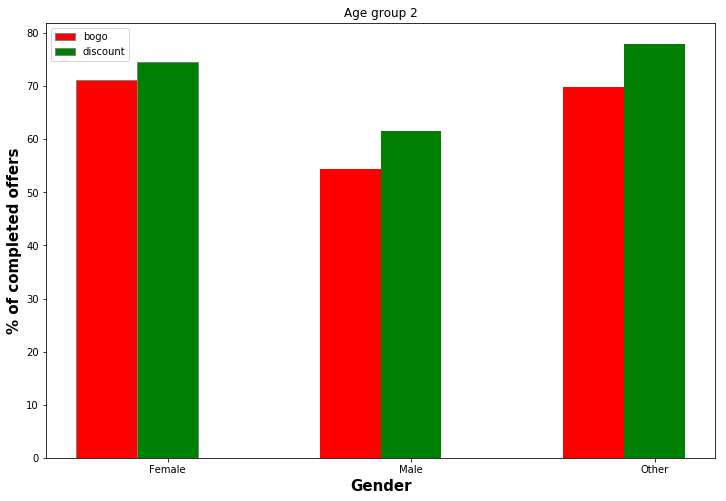

In [81]:
fig = plt.subplots(figsize =(12, 8))

barwidth= 0.25

br1 = np.arange(len(results_df[(results_df['age_group']==2)&(results_df['offer_type']=='bogo')]['gender']))
br2 = [x + barwidth for x in br1]
# Horizontal Bar Plot
plt.bar(br1, results_df[(results_df['age_group']==2)&(results_df['offer_type']=='bogo')]['compl_perc_value'],
       color ='r',width = barwidth,
        edgecolor ='grey', label ='bogo')
plt.bar(br2, results_df[(results_df['age_group']==2)&(results_df['offer_type']=='discount')]['compl_perc_value'], color ='g',width = barwidth,
        edgecolor ='grey', label ='discount') 

# Adding Xticks
plt.xlabel('Gender', fontweight ='bold', fontsize = 15)
plt.ylabel('% of completed offers', fontweight ='bold', fontsize = 15)
plt.xticks([r + barwidth for r in range(len(results_df[(results_df['age_group']==2)&(results_df['offer_type']=='bogo')]['gender']))],
        ['Female', 'Male', 'Other'])

plt.legend()
plt.title('Age group 2')
# Show Plot
plt.show()

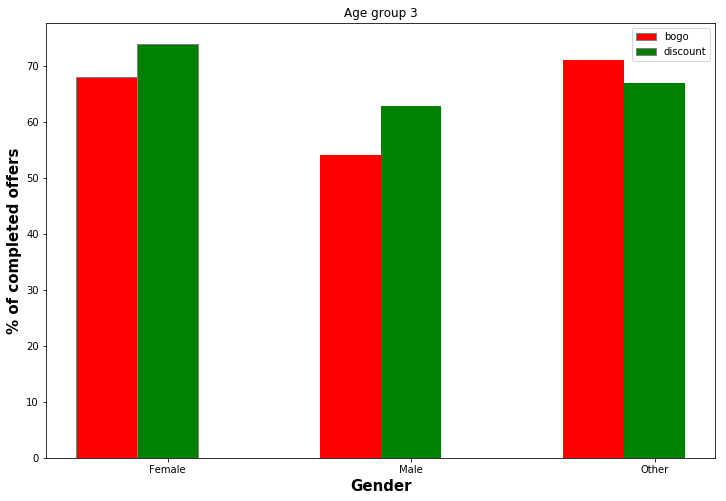

In [82]:
fig = plt.subplots(figsize =(12, 8))

barwidth= 0.25

br1 = np.arange(len(results_df[(results_df['age_group']==3)&(results_df['offer_type']=='bogo')]['gender']))
br2 = [x + barwidth for x in br1]
# Horizontal Bar Plot
plt.bar(br1, results_df[(results_df['age_group']==3)&(results_df['offer_type']=='bogo')]['compl_perc_value'],
       color ='r',width = barwidth,
        edgecolor ='grey', label ='bogo')
plt.bar(br2, results_df[(results_df['age_group']==3)&(results_df['offer_type']=='discount')]['compl_perc_value'], color ='g',width = barwidth,
        edgecolor ='grey', label ='discount') 

# Adding Xticks
plt.xlabel('Gender', fontweight ='bold', fontsize = 15)
plt.ylabel('% of completed offers', fontweight ='bold', fontsize = 15)
plt.xticks([r + barwidth for r in range(len(results_df[(results_df['age_group']==3)&(results_df['offer_type']=='bogo')]['gender']))],
        ['Female', 'Male', 'Other'])

plt.legend()
plt.title('Age group 3')
# Show Plot
plt.show()